# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [106]:
# Предпочтительные параметры
size = 9.765625E-6/64
near_N = 512*64 #2004 #1336
near_length = 5.0E-3
wavelength = 500.0E-9
masks_amount = 1
distance = 100.0E-3

# Параметры обучения
batch_size = 50
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'Adam'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 50

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       32768
Количество пикселей маски:                32768
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     152.588 нм
Расстояние между слоями:                  100.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    50
Размер батча:                             50
Тип оптимизатора:                         Adam


# Тестирование на различных датасетах

Критическое  значение Kz: 12.566 ·10⁶
Максимальное значение Kz: 26.266 ·10⁶


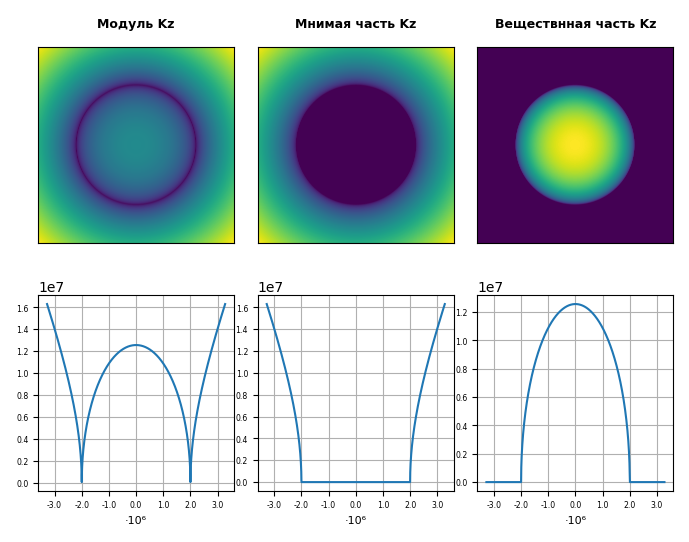

In [107]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.1)
propagation.delayed.launch()

mask = propagation.propagation_buffer.clone().detach().cpu().squeeze() / (1j * distance)
freq_x = torch.fft.fftshift(torch.fft.fftfreq(mask.shape[0], d=length/N))
freq_y = torch.fft.fftshift(torch.fft.fftfreq(mask.shape[0], d=length/N))
freq_x_mesh, freq_y_mesh = torch.meshgrid(freq_x, freq_y, indexing='ij')
K2 = ((1.0 / (wavelength))**2)
Kz = (2. * torch.pi * torch.sqrt(0j + K2 - freq_x_mesh**2 - freq_y_mesh**2))

mask = Kz
bolean = mask.imag == 0
dN1 = (mask.shape[0] - N) // 2
dN2 = mask.shape[0] - N - dN1

formatter, unit = scientific.separatedformatter(freq_x)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

plot.description.column.top("Модуль Kz", 0)
plot.description.column.top("Мнимая часть Kz", 1)
plot.description.column.top("Веществнная часть Kz", 2)

axes = plot.axes.add(0,0)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.imshow(mask.abs(), aspect='auto')
axes = plot.axes.add(0,1)
axes.grid(True)
axes.xaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
axes.plot(freq_x, mask.abs()[mask.shape[0]//2])

axes = plot.axes.add(1,0)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.imshow(mask.imag, aspect='auto')
axes = plot.axes.add(1,1)
axes.grid(True)
axes.xaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
axes.plot(freq_x, mask.imag[mask.shape[0]//2])

axes = plot.axes.add(2,0)
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
axes.imshow(mask.real, aspect='auto')
axes = plot.axes.add(2,1)
axes.grid(True)
axes.xaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
axes.plot(freq_x, mask.real[mask.shape[0]//2])

print(f"Критическое  значение Kz: {scientific(2*torch.pi/wavelength)}")
print(f"Максимальное значение Kz: {scientific(torch.max(Kz.abs()).item())}")

plot.show()

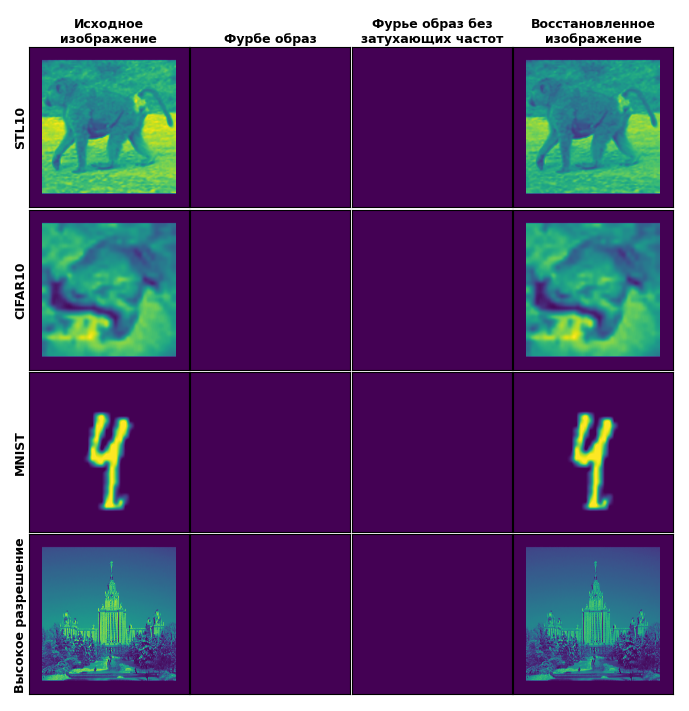

In [110]:
with torch.no_grad():
    images = []
    labels = ['STL10', 'CIFAR10', 'MNIST', 'Высокое разрешение']
    
    dataset = Dataset('STL10', 1, N, N, torch.complex64, threads=1, preload=10)
    images.append(next(iter(dataset.test))[0])
    
    dataset = Dataset('CIFAR10', 1, N, N, torch.complex64, threads=1, preload=10)
    images.append(next(iter(dataset.test))[0])
    
    dataset = Dataset('MNIST', 1, N, N, torch.complex64, threads=1, preload=10)
    images.append(next(iter(dataset.test))[0])
    
    temp = interpolate(torch.mean(torchvision.transforms.functional.pil_to_tensor(Image.open('../../figures/MSU.jpg')).to(torch.float32), dim=0).unsqueeze(0).unsqueeze(0), (N,N))
    images.append(temp)
    
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.column.top('Исходное изображение', 0)
    plot.description.column.top('Фурбе образ', 1)
    plot.description.column.top('Фурье образ без затухающих частот', 2)
    plot.description.column.top('Восстановленное изображение', 3)
    
    for row, (image, label) in enumerate(zip(images, labels)):
        plot.description.row.left(label, row)
        
        image = torchvision.transforms.functional.pad(image, (dN1,dN2,dN1,dN2))
        image_fft = torch.fft.fftshift(torch.fft.fft2(image))
        image_fft_croped = image_fft * bolean
        image_reconstructed = torch.fft.ifft2(torch.fft.ifftshift(image_fft_croped))

        image, image_fft, image_fft_croped, image_reconstructed = image.squeeze(), image_fft.squeeze(), image_fft_croped.squeeze(), image_reconstructed.squeeze()

        for i, picture in enumerate([image, image_fft, image_fft_croped, image_reconstructed]):
            axes = plot.axes.add(i,row)
            axes.xaxis.set_visible(False)
            axes.yaxis.set_visible(False)
            axes.imshow(picture.abs(), aspect='auto')
    
    plot.show()